# Cluster membership probability

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

# Astrometric solution

Open the file which contains the parameter values for each star in GES

In [2]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

# 1.2 Cluster choice

Here choosing open cluster Trumpler 14


In [4]:
OC=data[data['GES_FLD']=='NGC6705'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in OC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)
set(data['GES_FLD'])

{'134_Tau',
 '18_Sco',
 '25_Ori',
 '32_Gem',
 '67_Oph',
 '68_Tau',
 'Arcturus',
 'Assc50',
 'Blanco1',
 'Br20',
 'Br21',
 'Br22',
 'Br25',
 'Br29',
 'Br30',
 'Br31',
 'Br32',
 'Br36',
 'Br39',
 'Br44',
 'Br73',
 'Br75',
 'Br81',
 'Bulge',
 'Cha_I',
 'Col110',
 'Col197',
 'Col261',
 'Corot',
 'Cz24',
 'Cz30',
 'ESO92_05',
 'GES_MW_00_01',
 'GES_MW_01_02',
 'GES_MW_02_03',
 'GES_MW_03_04',
 'GES_MW_04_05',
 'GES_MW_05_06',
 'GES_MW_06_07',
 'GES_MW_07_08',
 'GES_MW_08_09',
 'GES_MW_09_10',
 'GES_MW_10_11',
 'GES_MW_11_12',
 'GES_MW_12_13',
 'GES_MW_13_14',
 'GES_MW_14_15',
 'GES_MW_15_16',
 'GES_MW_16_17',
 'GES_MW_17_18',
 'GES_MW_18_19',
 'GES_MW_19_20',
 'GES_MW_20_21',
 'GES_MW_21_22',
 'GES_MW_22_23',
 'GES_MW_23_24',
 'GJ205',
 'GJ388',
 'GJ436',
 'GJ526',
 'GJ551',
 'GJ581',
 'GJ699',
 'GJ880',
 'HD102200',
 'HD107328',
 'HD109061',
 'HD122563',
 'HD140283',
 'HD148897',
 'HD163758',
 'HD173819',
 'HD190056',
 'HD204587',
 'HD220009',
 'HD22879',
 'HD24937',
 'HD27271',
 'HD283',


# 1.3 Gaia Data input

Inputting a sample of data in the open cluster region.

In [5]:
ra=OC['RA'].astype(float)
dec=OC['DEC'].astype(float)
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius
selection_region=gaia_cone(center[0],center[1],radius/10)

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 282.76456067242276, -6.276987666135439)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 282.76456067242276, -6.276987666135439, 0.054573110524885914)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Tue, 01 Mar 2022 12:16:45 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=blo

# 1.4 Visualising the sample

The Gaia values are in the higher density regions.

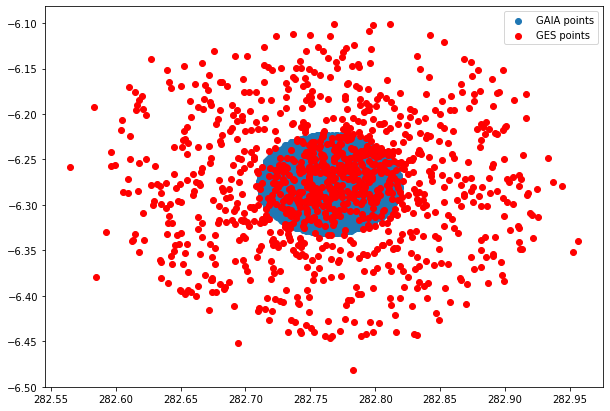

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

# 1.5 Merging dataframes

We want to have a dataframe and if theres a match in GES then that column gets added.

In [7]:
OC['GAIA_eDR3_ID']=OC['GAIA_eDR3_ID'].astype(int)
selection_region['GAIA_eDR3_ID']=selection_region['source_id']
selection_region

,index,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,GAIA_eDR3_ID
0,0,1636042515805110273,Gaia EDR3 4252499140417032832,4252499140417032832,1222132258,2016.0,282.777192,0.056443,-6.327085,0.052233,...,0,NaN,NaN,NaN,27.258972,-2.807522,283.254998,16.526201,0.051646,4252499140417032832
1,1,1636042515805110273,Gaia EDR3 4252499140423382272,4252499140423382272,438587348,2016.0,282.775844,0.030224,-6.328418,0.030033,...,0,NaN,NaN,NaN,27.257174,-2.806934,283.253479,16.524997,0.052639,4252499140423382272
2,2,1636042515805110273,Gaia EDR3 4252499140445900160,4252499140445900160,490600398,2016.0,282.776490,0.340189,-6.328760,0.339439,...,0,NaN,NaN,NaN,27.257160,-2.807661,283.254113,16.524597,0.053113,4252499140445900160
3,3,1636042515805110273,Gaia EDR3 4252499144794910336,4252499144794910336,1476487722,2016.0,282.779443,0.273048,-6.328988,0.289339,...,0,NaN,NaN,NaN,27.258290,-2.810379,283.257139,16.524100,0.054064,4252499144794910336
4,4,1636042515805110273,Gaia EDR3 4252499144794923264,4252499144794923264,840769867,2016.0,282.777581,0.139409,-6.329245,0.143240,...,0,NaN,NaN,NaN,27.257220,-2.808846,283.255192,16.524015,0.053835,4252499144794923264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,6936,1636042515805110273,Gaia EDR3 4252505329581739392,4252505329581739392,790254297,2016.0,282.776531,0.094813,-6.223806,0.128181,...,0,NaN,NaN,NaN,27.350807,-2.760056,283.264206,16.629104,0.054497,4252505329581739392
4358,6937,1636042515805110273,Gaia EDR3 4252505329581743488,4252505329581743488,1305781186,2016.0,282.772787,0.024525,-6.225058,0.029697,...,0,NaN,NaN,NaN,27.347999,-2.757308,283.260218,16.628199,0.052569,4252505329581743488
4359,6938,1636042515805110273,Gaia EDR3 4252505329581744256,4252505329581744256,231180782,2016.0,282.771541,0.034368,-6.225587,0.051677,...,0,NaN,NaN,NaN,27.346964,-2.756445,283.258880,16.627786,0.051867,4252505329581744256
4360,6939,1636042515805110273,Gaia EDR3 4252505329581750656,4252505329581750656,422895612,2016.0,282.769925,0.876101,-6.223911,1.116347,...,0,NaN,NaN,NaN,27.347728,-2.754252,283.257371,16.629602,0.053344,4252505329581750656


In [8]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(OC['GAIA_eDR3_ID'].astype(int).values)]

In [9]:
gaia_not_eso=selection_region[~selection_region['GAIA_eDR3_ID'].isin(OC['GAIA_eDR3_ID'].astype(int).values)]

We create two dataframes, one with all of the GAIA ESO values and another which comes from GAIA only.

In [10]:
gaia_eso=pd.DataFrame.merge(OC, gaia_df_gc,on='GAIA_eDR3_ID')

# 1.6.1 Global corections

Remove G>18
What about the parallax zero point?

https://arxiv.org/pdf/2108.02783.pdf

We use the recommendations from 294 Lindegren et al. (2018) to account for systematics found 295 within the parallax and proper-motion data. In par- 296 ticular, we subtract the -0.029 mas parallax zero-point 297 from all of our stars and exclude all stars fainter than 298 18th Gaia G magnitude.

In [11]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['phot_g_mean_mag']<=18.0]
gaia_eso=gaia_eso[gaia_eso['phot_g_mean_mag']<=18.0]

In [12]:
gaia_not_eso

,index,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,GAIA_eDR3_ID
1,1,1636042515805110273,Gaia EDR3 4252499140423382272,4252499140423382272,438587348,2016.0,282.775844,0.030224,-6.328418,0.030033,...,0,NaN,NaN,NaN,27.257174,-2.806934,283.253479,16.524997,0.052639,4252499140423382272
7,12,1636042515805110273,Gaia EDR3 4252499144828632192,4252499144828632192,783985481,2016.0,282.777029,0.029745,-6.327483,0.028784,...,0,NaN,NaN,NaN,27.258543,-2.807559,283.254792,16.525820,0.051994,4252499144828632192
9,15,1636042515805110273,Gaia EDR3 4252499174783142272,4252499174783142272,682041603,2016.0,282.783294,0.047128,-6.326547,0.047711,...,0,NaN,NaN,NaN,27.262207,-2.812682,283.261349,16.526180,0.052942,4252499174783142272
11,17,1636042515805110273,Gaia EDR3 4252499174805889920,4252499174805889920,837383930,2016.0,282.789044,0.112501,-6.323154,0.117752,...,0,NaN,NaN,NaN,27.267832,-2.816235,283.267610,16.529034,0.052188,4252499174805889920
26,39,1636042515805110273,Gaia EDR3 4252499179154648192,4252499179154648192,1786708270,2016.0,282.783355,0.428257,-6.325090,0.433928,...,0,NaN,NaN,NaN,27.263535,-2.812074,283.261551,16.527626,0.051602,4252499179154648192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353,6931,1636042515805110273,Gaia EDR3 4252505329581725056,4252505329581725056,1052359696,2016.0,282.782318,0.046225,-6.225872,0.055218,...,0,NaN,NaN,NaN,27.351579,-2.766120,283.269987,16.626518,0.054078,4252505329581725056
4355,6934,1636042515805110273,Gaia EDR3 4252505329581735296,4252505329581735296,1690200917,2016.0,282.777547,0.049317,-6.224644,0.059676,...,0,NaN,NaN,NaN,27.350519,-2.761336,283.265175,16.628177,0.053912,4252505329581735296
4356,6935,1636042515805110273,Gaia EDR3 4252505329581737344,4252505329581737344,1158817414,2016.0,282.777437,0.034913,-6.224052,0.043778,...,0,NaN,NaN,NaN,27.350997,-2.760969,283.265118,16.628777,0.054461,4252505329581737344
4357,6936,1636042515805110273,Gaia EDR3 4252505329581739392,4252505329581739392,790254297,2016.0,282.776531,0.094813,-6.223806,0.128181,...,0,NaN,NaN,NaN,27.350807,-2.760056,283.264206,16.629104,0.054497,4252505329581739392


# 1.6.2 Proper motion cuts

When making cuts we are going to assume that the GAIA ESO is a 'good' sample and use its values to define the bounds.

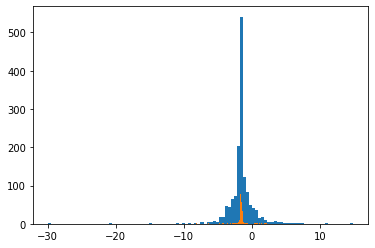

In [13]:
plt.hist(gaia_not_eso['pmra'],bins=100)
plt.hist(gaia_eso['pmra'],bins=100)
plt.show()

 Make a 3 sigma clip on proper motion

In [14]:
bound=[gaia_eso['pm'].median()-3*gaia_eso['pm'].std(),gaia_eso['pm'].median()+3*gaia_eso['pm'].std()]

In [15]:
truth1=gaia_not_eso['pm']>=bound[0]
truth2=gaia_not_eso['pm']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]
len(gaia_not_eso)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_11945/1106090040.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


1309

In [16]:
truth1=gaia_eso['pm']>=bound[0]
truth2=gaia_eso['pm']<=bound[1]
gaia_eso=gaia_eso[truth1]
gaia_eso=gaia_eso[truth2]
len(gaia_eso)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_11945/2708646260.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_eso=gaia_eso[truth2]


316

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

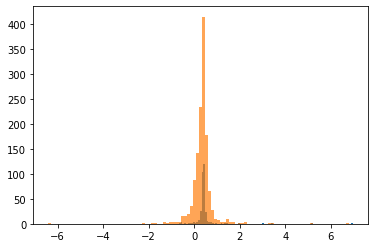

In [17]:
plt.hist(gaia_eso['parallax'],bins=100)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.7)
plt.show()

In [18]:
np.std(gaia_eso['parallax'])

0.5506742635726721

In [19]:
bound=[gaia_eso['parallax'].median()-3*gaia_eso['parallax'].std(),gaia_eso['parallax'].median()+3*gaia_eso['parallax'].std()]

In [20]:
truth1=gaia_not_eso['parallax']>=bound[0]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth1]
gaia_not_eso=gaia_not_eso[truth2]
len(gaia_not_eso)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_11945/3676889474.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_not_eso=gaia_not_eso[truth2]


1293

In [21]:
truth1=gaia_eso['parallax']>=bound[0]
truth2=gaia_eso['parallax']<=bound[1]
gaia_eso=gaia_eso[truth1]
gaia_eso=gaia_eso[truth2]
len(gaia_eso)

312

In [22]:
gaia_not_eso['parallax'].min()

-1.1897309393399864

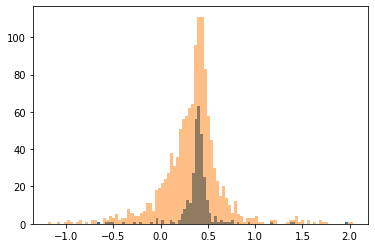

In [23]:

plt.hist(gaia_eso['parallax'],bins=90)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.5)
plt.show()

Even after the parallax cut of 3 sigma there are still plenty of sources.

After making a very conservative cut we are going to attempt to fit the BNN with error.

# 1.7 Making Data into Learning Format.

In [24]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']



(array([  4.,   3.,   8., 123., 163.,   6.,   2.,   2.,   0.,   1.]),
 array([-0.67486935, -0.40893106, -0.14299278,  0.12294551,  0.38888379,
         0.65482208,  0.92076036,  1.18669865,  1.45263694,  1.71857522,
         1.98451351]),
 <BarContainer object of 10 artists>)

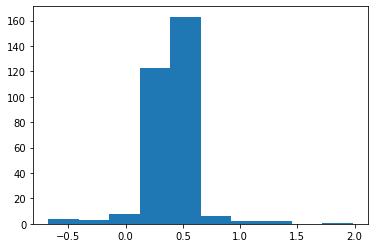

In [25]:
plt.hist((gaia_eso['parallax'].astype(float)))

The radial velocity of >300 is so massively diferent can I assume to cut it out?

In [26]:
gaia_eso=gaia_eso[gaia_eso.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]



In [27]:

data=pd.concat([gaia_eso, gaia_not_eso])
input_cluster_data=data[columns_parameters]
input_cluster_data


,ra,dec,parallax,VRAD,pmra,pmdec
0,282.710321,-6.278753,0.396054,39.33,-1.791964,-4.305723
1,282.710874,-6.282940,0.368062,35.97,-1.611503,-4.198678
2,282.712898,-6.275663,0.412074,59.82,-2.426381,-2.357655
3,282.717055,-6.292275,0.365371,42.04,-1.431360,-4.051047
4,282.718301,-6.268675,0.340622,35.54,-1.348803,-4.054045
...,...,...,...,...,...,...
4353,282.782318,-6.225872,0.528051,NaN,-0.281051,-4.229405
4355,282.777547,-6.224644,-0.040023,NaN,-1.490405,-1.687877
4356,282.777437,-6.224052,0.100997,NaN,-4.626195,-5.771132
4357,282.776531,-6.223806,0.644849,NaN,-1.289467,-3.823155


In [28]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([gaia_eso, gaia_not_eso])[columns_error]

# Covariance Error matrix

In [29]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

This follows the paper linked later. The matrix R I use is a diagonal matrix with 1 in the nth position if we have a data reading for the nth feature, and zero otherwise.

For the moment we don't need it to be very complex as we are going to only have two different cases, i.e whether or not a value has radial velocity. 

In [30]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [31]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)

# Definitions of the learning inputs

In [32]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix
learning_R=R


# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In this section I'm following the above paper which adapts the GMM to noisy and missing data. I only apply this to the Gaia eso data at first, and using astrometric data.

Using Bayes Law:
$$ P(C | D)= P(D|C)P(C)\over{P(D)}$$
Let $\textbf{w}_{i}$ be the vector of observed data, and $\textbf{x}_i$ be the vector of 'true' values. Let $R$ be the matrix which projects $\textbf{x}_i$ to $\textbf{w}_i$ and let $S_i$ be a known covariance matrix, so that we assume $$\textbf{w}_i=R_i\textbf{x}_i + \text{noise}$$ where the noise is drawn from a Gaussian distribution with mean 0 and covariance $S_i$

Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [33]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Analysis')

In [34]:
%load_ext autoreload
%autoreload 2

# We are only using the Data which is in Gaia Eso and some of the Gaia data now as we have a few bugs to fix.

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

One part uses all the GES data and other uses both Gaia eso and gaia.

In [35]:
gmm_GES=XDGMM(2).fit(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

gmm_full=XDGMM(2).fit(learning_input,Xerr=learning_error_covariance,R=R)

gmm
endgmm
gmm
endgmm


# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$


The prior is $p(z=i|\theta)=\alpha_i$. This is the posterior probability that an observation has been generated from the $i^{th}$ component

Just Using Gaia ESO Data

In [36]:

prob_ges=gmm_GES.prob_z_given_w(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

Plotting

In [37]:
df=pd.DataFrame(learning_input[0:len(gaia_eso)],columns=columns_parameters)
df2=pd.DataFrame(prob_ges[:,1][0:len(gaia_eso)],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.710321,-6.278753,0.396054,39.33,-1.791964,-4.305723,9.997498e-01
1,282.710874,-6.282940,0.368062,35.97,-1.611503,-4.198678,9.999573e-01
2,282.712898,-6.275663,0.412074,59.82,-2.426381,-2.357655,1.076820e-45
3,282.717055,-6.292275,0.365371,42.04,-1.431360,-4.051047,9.997191e-01
4,282.718301,-6.268675,0.340622,35.54,-1.348803,-4.054045,9.998135e-01
...,...,...,...,...,...,...,...
307,282.816409,-6.262129,0.430753,38.49,-1.844373,-4.043580,9.997525e-01
308,282.816928,-6.277877,0.251857,-1.60,-2.746439,-2.230388,1.201647e-74
309,282.817207,-6.273903,0.380698,41.25,-1.635942,-4.250173,9.998478e-01
310,282.817877,-6.281952,0.324577,34.14,-1.663671,-4.001948,9.995019e-01


In [38]:
sum(plot_df[0:len(gaia_eso)]['prob']>=0.99)

224

Just training and evaluating on the original sample gives 400 members with probability >=0.99

We not plot these values vs their membership.

# GAIA ESO Train and evaluate.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

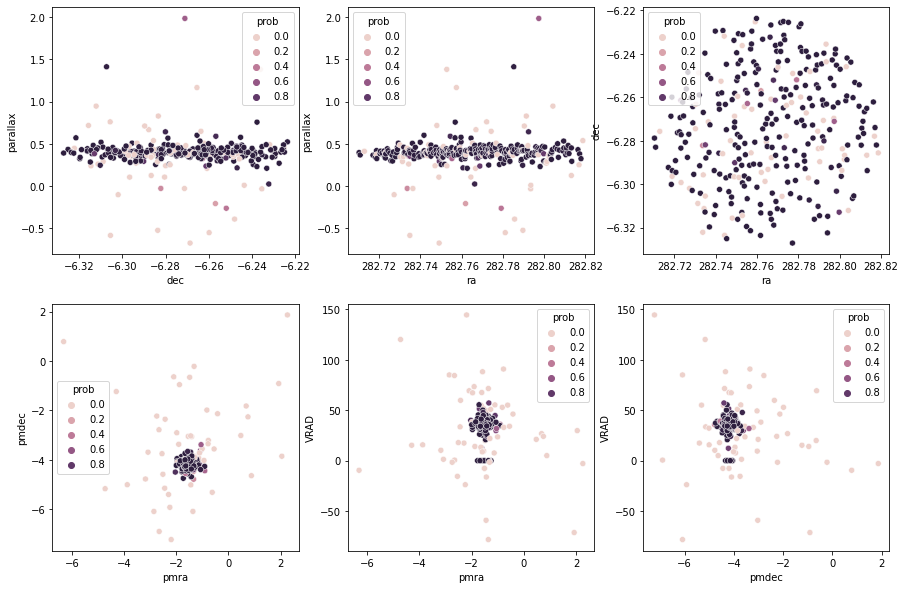

In [39]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# GAIA ESO and GAIA Train and evaluate.

In [40]:

prob_full=gmm_full.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(prob_full[:,1],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.710321,-6.278753,0.396054,39.33,-1.791964,-4.305723,1.000000e+00
1,282.710874,-6.282940,0.368062,35.97,-1.611503,-4.198678,1.000000e+00
2,282.712898,-6.275663,0.412074,59.82,-2.426381,-2.357655,1.000000e+00
3,282.717055,-6.292275,0.365371,42.04,-1.431360,-4.051047,1.000000e+00
4,282.718301,-6.268675,0.340622,35.54,-1.348803,-4.054045,1.000000e+00
...,...,...,...,...,...,...,...
1600,282.782318,-6.225872,0.528051,0.00,-0.281051,-4.229405,1.920974e-01
1601,282.777547,-6.224644,-0.040023,0.00,-1.490405,-1.687877,3.336683e-09
1602,282.777437,-6.224052,0.100997,0.00,-4.626195,-5.771132,9.395637e-14
1603,282.776531,-6.223806,0.644849,0.00,-1.289467,-3.823155,9.443223e-01


In [41]:
sum(plot_df[0:len(gaia_eso)]['prob']>=0.99)

300

Now there are only 70 objects in the original GES sample which are identified as being part of the cluster, this is verified by the following plots.

GAIA ESO AND GAIA

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

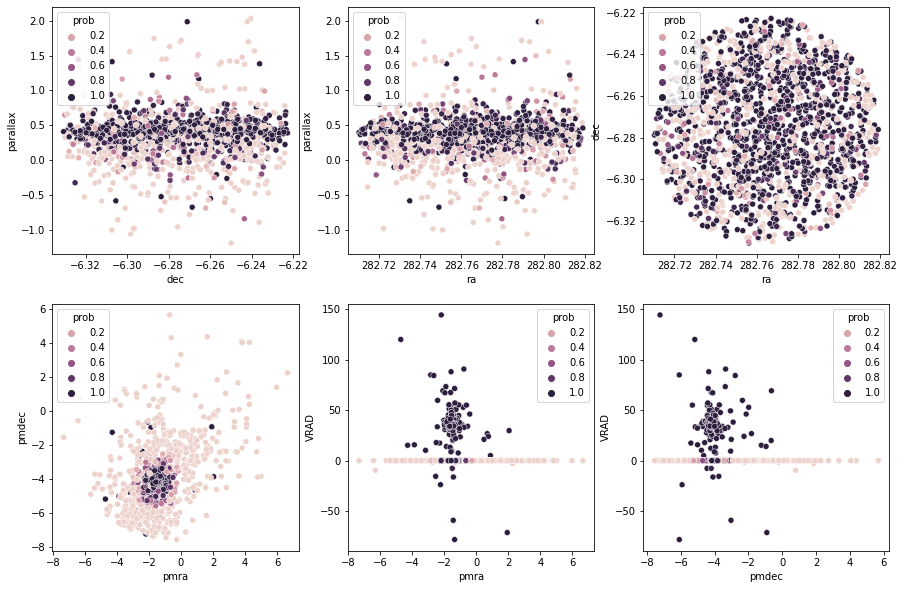

In [42]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# 2.2 Train on Gaia ESO and evaluate on GAIA plus GAIA ESO

We now see what happens if we train on a 'good' sample, that being the GAIA ESO and then apply to a much larger data set, with also less information attached to it.

In [43]:

comp=gmm_GES.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,1],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.710321,-6.278753,0.396054,39.33,-1.791964,-4.305723,9.997498e-01
1,282.710874,-6.282940,0.368062,35.97,-1.611503,-4.198678,9.999573e-01
2,282.712898,-6.275663,0.412074,59.82,-2.426381,-2.357655,1.076820e-45
3,282.717055,-6.292275,0.365371,42.04,-1.431360,-4.051047,9.997191e-01
4,282.718301,-6.268675,0.340622,35.54,-1.348803,-4.054045,9.998135e-01
...,...,...,...,...,...,...,...
1600,282.782318,-6.225872,0.528051,0.00,-0.281051,-4.229405,4.934852e-14
1601,282.777547,-6.224644,-0.040023,0.00,-1.490405,-1.687877,2.197480e-57
1602,282.777437,-6.224052,0.100997,0.00,-4.626195,-5.771132,9.798600e-103
1603,282.776531,-6.223806,0.644849,0.00,-1.289467,-3.823155,5.129228e-01


In [44]:
sum(plot_df[0:len(gaia_eso)]['prob']>=0.99)

224

As we expect this gives us the same number of members >=0.99 probability from the Gaia_eso sample

Now we see this evaluated on our full dataset.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

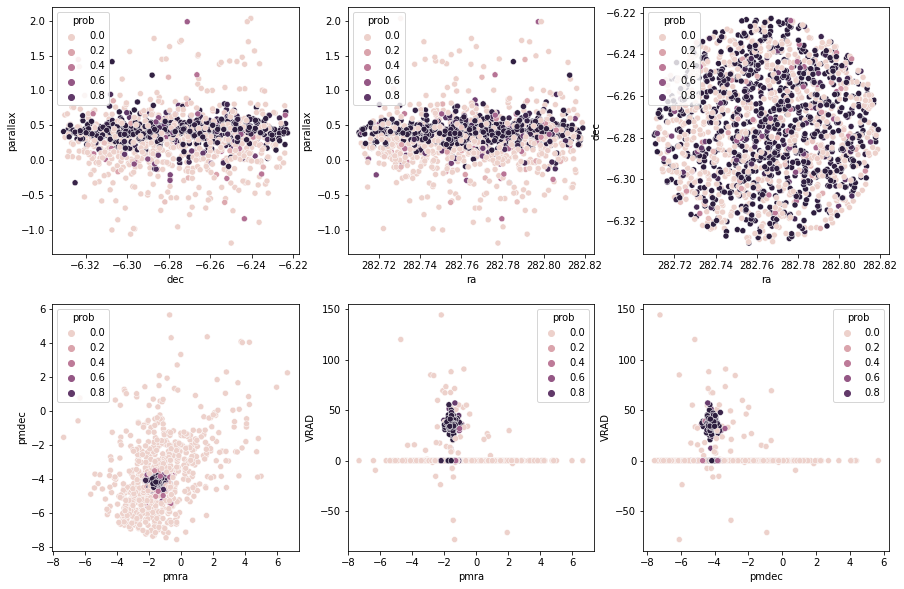

In [45]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Now we evaluate it only on the GAIA data

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

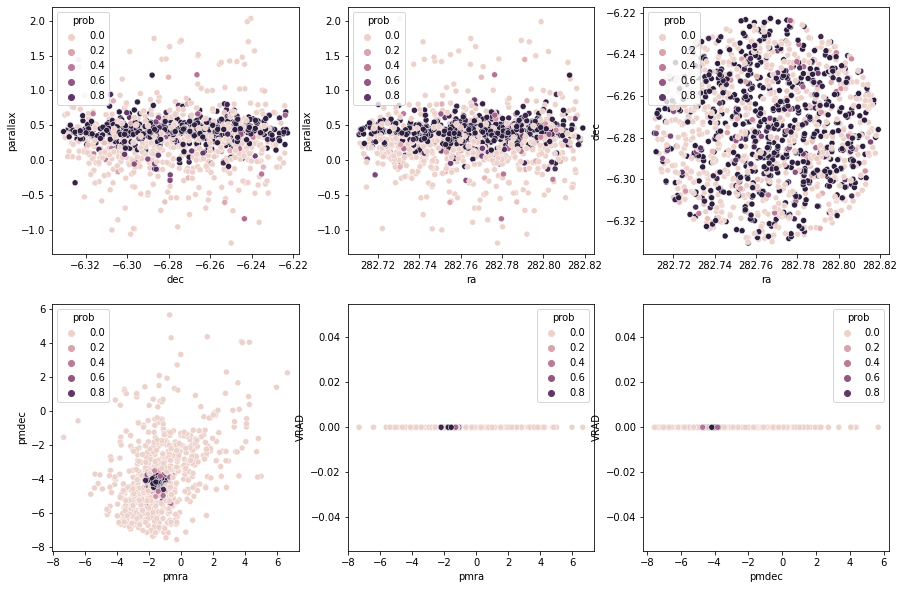

In [46]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Colour Magnitude Diagrams

https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

In [47]:
df_diagram=pd.concat([plot_df.reset_index(),data[['bp_rp','phot_g_mean_mag']].reset_index()],axis=1)


In [48]:
data_for_hr1=df_diagram[df_diagram['prob']>=0.9]
data_for_hr2=df_diagram[df_diagram['prob']<0.9]

(array([  1.,   1.,  18.,  55.,  83., 131., 220., 269., 317., 510.]),
 array([ 8.3636875,  9.327313 , 10.290939 , 11.254566 , 12.218192 ,
        13.181818 , 14.145444 , 15.10907  , 16.072697 , 17.036322 ,
        17.999949 ], dtype=float32),
 <BarContainer object of 10 artists>)

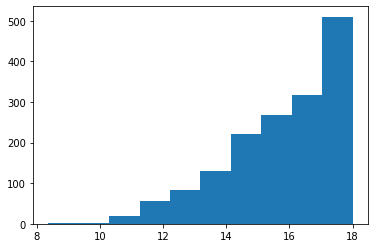

In [55]:
plt.hist(df_diagram['phot_g_mean_mag'])

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_11945/85041370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10((selection_gaia['parallax']))+5


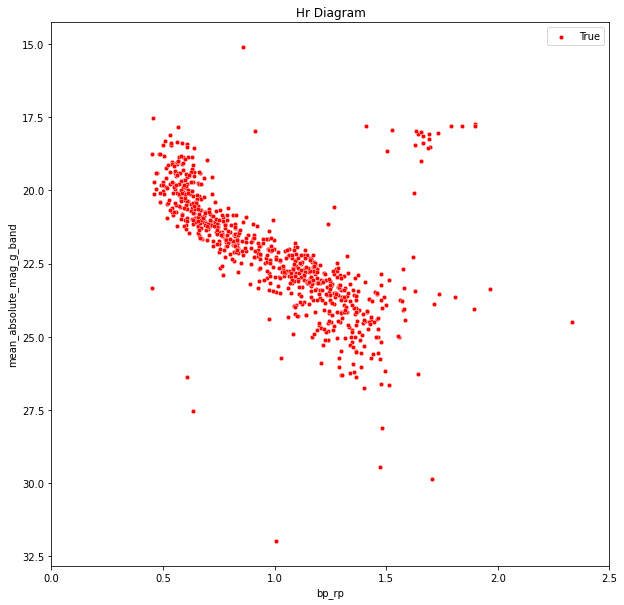

In [54]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10((1.0/selection_gaia['parallax']))+5
    return selection_gaia




f, axes = plt.subplots(1, 1)

f.set_figheight(10)
f.set_figwidth(10)
scatter=mean_basolute_mag_g_band(data_for_hr1)
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True',s=20,color='r')

#scatter=mean_basolute_mag_g_band(data_for_hr2)
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

axes.set_xlim(0,2.5)

axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram")
plt.show()

# Posterior.
https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

# Next need to use the found parameters to custom define a Gaussian mixture model and then do so to estimate probablilities.